# **Titanic colorful EDA 🚢**

### Hi kagglers 👋👋👋

### This is just a small colorful EDA kernel to extract knowledge from the data. Feel free to fork this notebook and contribute by adding graphs and analysis !

<img src="./images/train_meme.jpg" width="370" height="200" />  <img src="./images/test_meme.jpg" width="250" height="200" />

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Path of datasets
train_df_raw = pd.read_csv('./datasets/train.csv')
train_df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
def preprocess_data(df, numeric = True):
    
    processed_df = df.copy()
    processed_df['Embarked'].fillna('C', inplace=True)
    processed_df['Cabin'].fillna('U', inplace=True)
    processed_df['Title'] = pd.Series((name.split('.')[0].split(',')[1].strip() for name in processed_df['Name']), index=processed_df.index)
    processed_df['Title'] = processed_df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    processed_df['Title'] = processed_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    processed_df['Title'] = processed_df['Title'].replace('Mme', 'Mrs')
    processed_df['FamillySize'] = processed_df['SibSp'] + processed_df['Parch'] + 1
    processed_df['IsAlone'] = np.where(processed_df['FamillySize']!=1, 0, 1)
    processed_df['IsChild'] = processed_df['Age'] < 18
    processed_df['Deck'] = processed_df['Cabin'].str[:1]
    
    if not numeric:
        processed_df['FamillySize'][processed_df['FamillySize'].between(1, 5, inclusive=False)] = 2
        processed_df['FamillySize'][processed_df['FamillySize']>5] = 3
        processed_df['FamillySize'] = processed_df['FamillySize'].map({1: 'Alone', 2: 'Medium Familly', 3: 'Large Familly'})
        processed_df['IsAlone'] = processed_df['IsAlone'].map({0: 'Not Alone', 1: 'Alone'})
        processed_df['Embarked'] = processed_df['Embarked'].map({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'})

    if numeric:
        processed_df['Title'] = processed_df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
        processed_df['Sex'] = processed_df['Sex'].map({'male': 0, 'female': 1})
        processed_df['Embarked'] = processed_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
        processed_df['IsChild'] = processed_df['IsChild'].astype(int)
        processed_df['Deck'] = processed_df['Deck'].map({cabin: p for p, cabin in enumerate(set(cab for cab in processed_df['Deck']))})

    processed_df = processed_df.drop(['Name', 'Ticket', 'PassengerId', 'Cabin'], 1)  

    return processed_df

In [4]:
train_df_num = preprocess_data(train_df_raw)
train_df_num.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamillySize,IsAlone,IsChild,Deck
0,0,3,0,22.0,1,0,7.2500,0,1,2,0,0,2
1,1,1,1,38.0,1,0,71.2833,1,3,2,0,0,3
2,1,3,1,26.0,0,0,7.9250,0,2,1,1,0,2
3,1,1,1,35.0,1,0,53.1000,0,3,2,0,0,3
4,0,3,0,35.0,0,0,8.0500,0,1,1,1,0,2


In [5]:
train_df_cat = preprocess_data(train_df_raw, numeric = False)
train_df_cat.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamillySize,IsAlone,IsChild,Deck
0,0,3,male,22.0,1,0,7.2500,Southampton,Mr,Medium Familly,Not Alone,False,U
1,1,1,female,38.0,1,0,71.2833,Cherbourg,Mrs,Medium Familly,Not Alone,False,C
2,1,3,female,26.0,0,0,7.9250,Southampton,Miss,Alone,Alone,False,U
3,1,1,female,35.0,1,0,53.1000,Southampton,Mrs,Medium Familly,Not Alone,False,C
4,0,3,male,35.0,0,0,8.0500,Southampton,Mr,Alone,Alone,False,U


## **Distributions of variables**

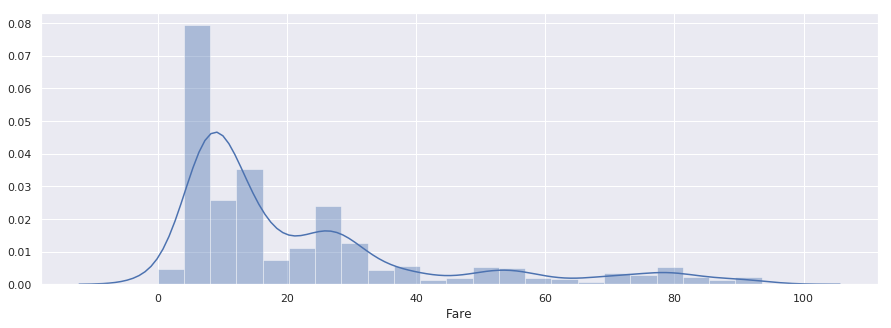

In [6]:
plt.figure(figsize=(15, 5))
train_df_num_without_fareoutliers = train_df_num[train_df_num['Fare'] < 100]
sns.distplot(train_df_num_without_fareoutliers.Fare)
plt.show()

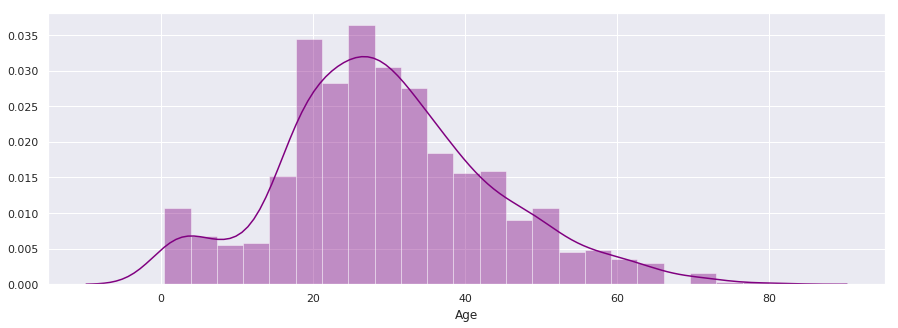

In [7]:
plt.figure(figsize=(15, 5))
sns.distplot(train_df_num.Age.interpolate(), color='purple')
plt.show()

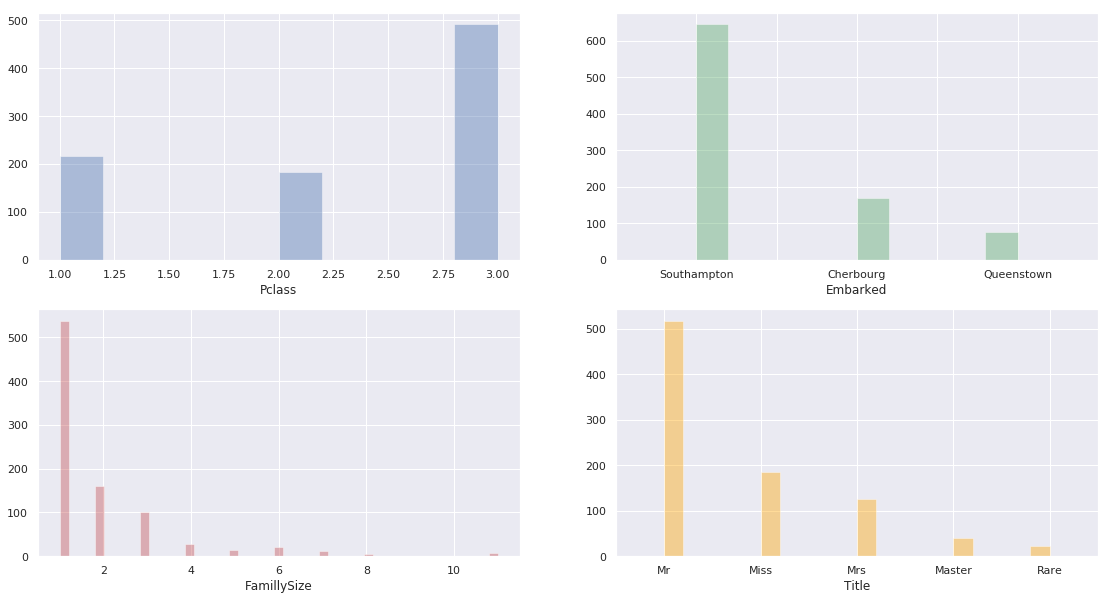

In [8]:
f,axes = plt.subplots(2, 2,figsize=(19,10))
sns.distplot(train_df_num.Pclass, kde=False, ax=axes[0][0])
g1 = sns.distplot(train_df_num.Embarked, kde=False, color='g', ax=axes[0][1])
g1.set(xlim=(-0.5, 2.5), xticklabels=['', "Southampton",'', "Cherbourg",'', "Queenstown"])
sns.distplot(train_df_num.FamillySize, kde=False, color='r', ax=axes[1][0])
g2 = sns.distplot(train_df_num.Title, kde=False, color='orange', ax=axes[1][1])
g2.set(xlim=(0.5, 5.5), xticklabels=[ '', "Mr", "Miss", "Mrs", "Master", "Rare"])
plt.show()

## **Survivor analysis**

### How many passenger survived ?

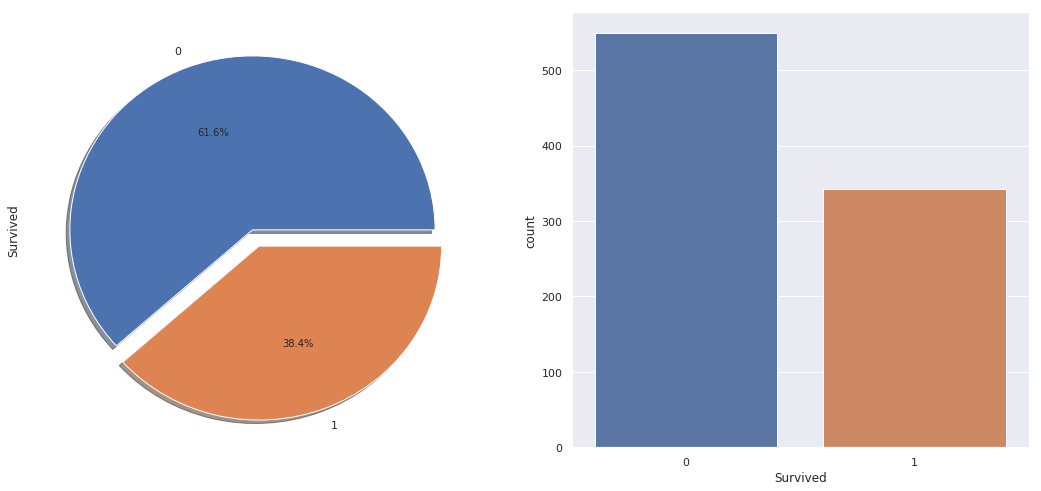

In [9]:
f,axes = plt.subplots(1,2,figsize=(18,8))
train_df_cat['Survived'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True)
sns.countplot('Survived',data=train_df_cat,ax=axes[1])
plt.show()

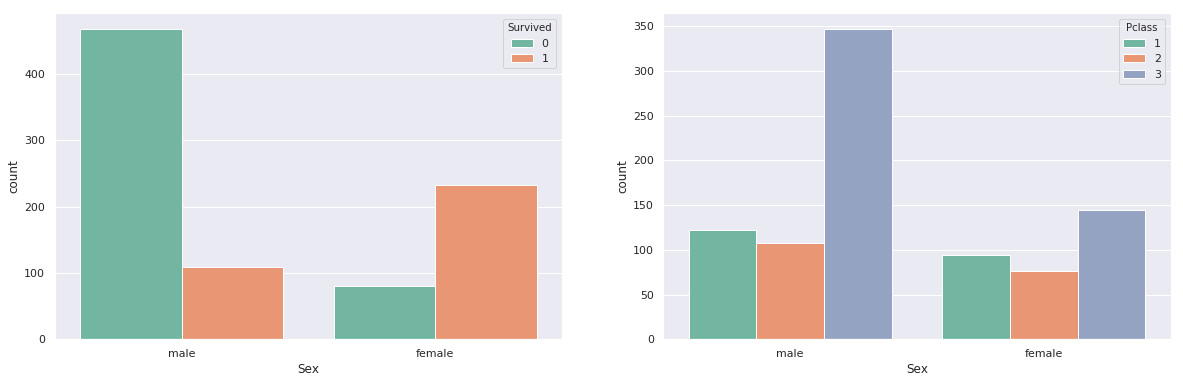

In [10]:
figure, axes = plt.subplots(1,2,figsize=(20,6))
sns.countplot('Sex',hue='Survived',data=train_df_cat, palette=("Set2"), ax=axes[0])
sns.countplot('Sex',hue='Pclass',data=train_df_cat, palette=("Set2"), ax=axes[1])
plt.show()

### There are much more men than mowen on the boat. However we can observe a famale/male parity in the 1st and 2nd class passengers, the imbalance appears only for third class passenger.

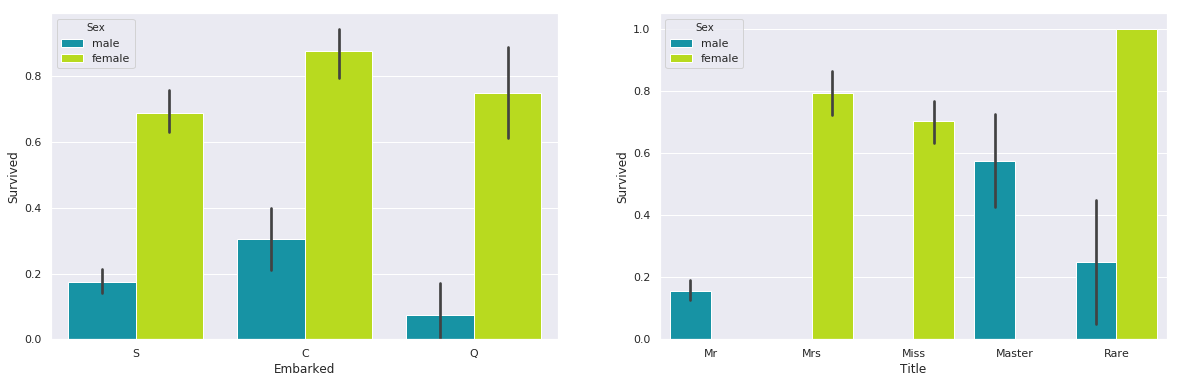

In [11]:
figure, axes = plt.subplots(1,2,figsize=(20,6))
g1 = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=train_df_raw, kind="bar", palette=("nipy_spectral"), ax=axes[0])
g2 = sns.catplot(x="Title", y="Survived", hue="Sex", data=train_df_cat, kind="bar", palette=("nipy_spectral"), ax=axes[1])
plt.close(g1.fig)
plt.close(g2.fig)
plt.show()

### It seems that passengers who comes from Cherbourg are more probable to survived, regardless of sex. Male masters have a very high survival rate, you definitely had to be a master when you were a man to increases your chances to survive.

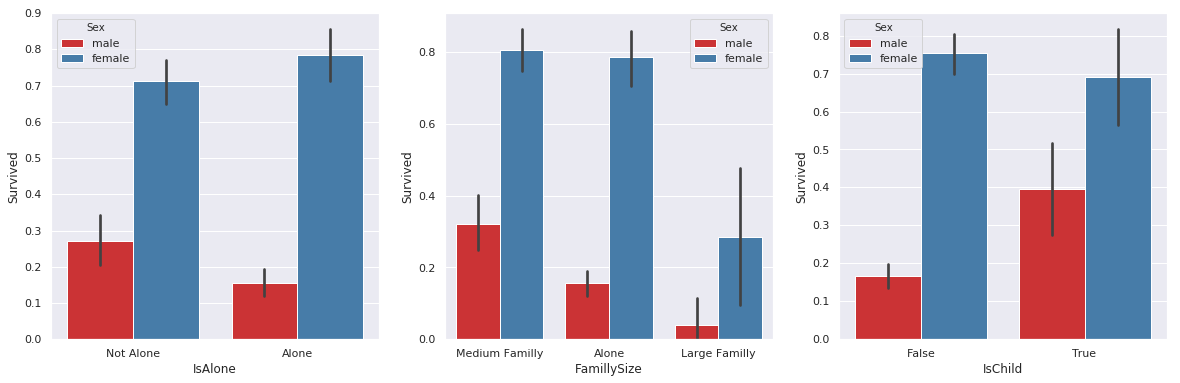

In [12]:
figure, axes = plt.subplots(1,3,figsize=(20, 6))
g1 = sns.catplot(x="IsAlone", y="Survived", hue="Sex", data=train_df_cat, kind="bar", palette=('Set1'), ax=axes[0])
g2 = sns.catplot(x="FamillySize", y="Survived", hue="Sex", data=train_df_cat, kind="bar", palette=('Set1'), ax=axes[1])
g3 = sns.catplot(x="IsChild", y="Survived", hue="Sex", data=train_df_cat, kind="bar", palette=('Set1'), ax=axes[2])
plt.close(g1.fig)
plt.close(g2.fig)
plt.close(g3.fig)
plt.show()

### For men, it's better not to be alone whereas women have higher survival probability by not having family on the boat. Survival probability increases for men when they have a large familly. In general, having too large familly (i.e. > 5 members) reduces the chances of survival. For being a child or not, its the same constat as for being alone : yes for man, no for female.

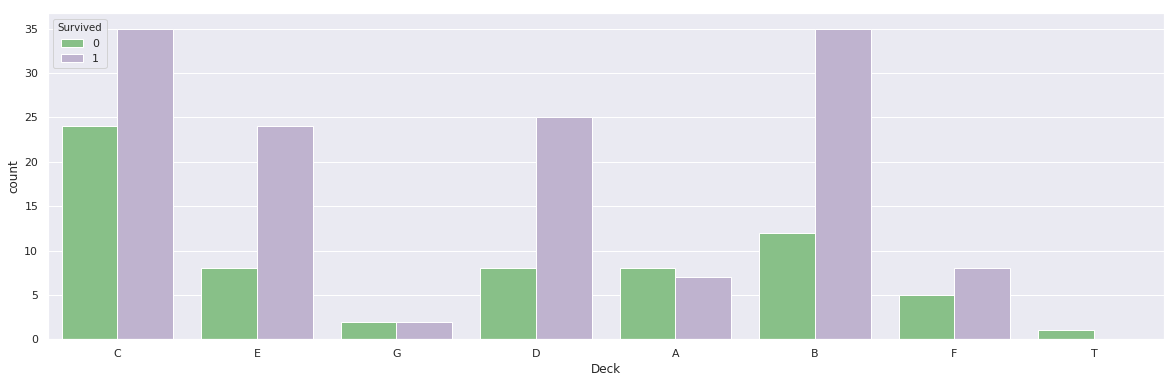

In [13]:
plt.figure(figsize=(20, 6))
train_df_cat_without_u_deck = train_df_cat.drop(train_df_cat[train_df_cat.Deck == 'U'].index)
plot = sns.countplot(x="Deck", hue="Survived", data=train_df_cat_without_u_deck, palette=('Accent'))
plt.show()

### Apparently, some decks are better than others. Let's check if the deck is related to fare or PClass. Do we put rich people on safer places on the Titanic ? 😏

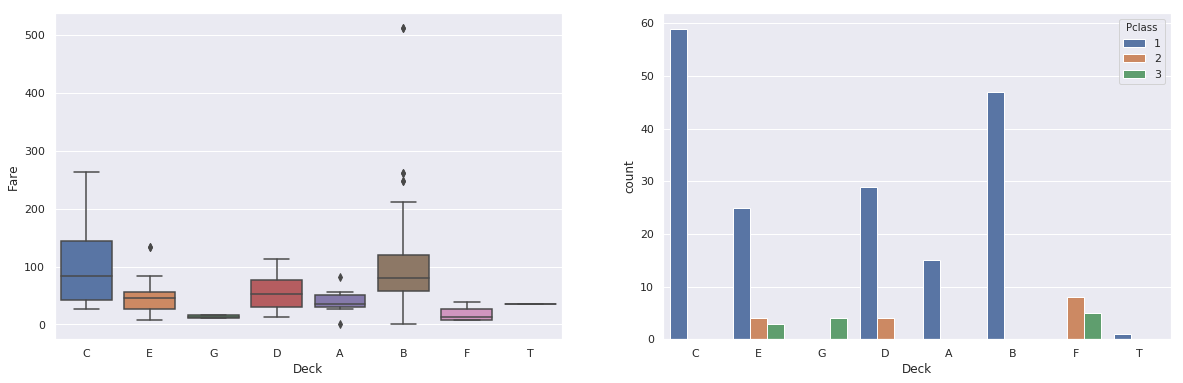

In [14]:
figure, axes = plt.subplots(1,2,figsize=(20,6))
g1 = sns.boxplot(x="Deck", y="Fare", data=train_df_cat_without_u_deck, ax=axes[0])
g2 = sns.countplot(x="Deck", hue="Pclass", data=train_df_cat_without_u_deck, ax=axes[1])
plt.show()

### Deck B is full of 1st class passenger and the mean fare for a cabin in this deck is near 100$, higher than other decks... It may be a coincidence but it is alse the safest decks, i.e. deck with the highest survival rates, according to the previous plot. However, column C has also high fare and is full of 1st class passenger but its survival rate is not so good (~60%). Moreover, it difficult to get some conclusion about deck considering the lack of data for this column.

*to be continued ...*